### MLOps

In [37]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
## read the data using Pandas
yellow_01 = pd.read_parquet('yellow_tripdata_2022-01.parquet')
yellow_02 = pd.read_parquet('yellow_tripdata_2022-02.parquet')

In [3]:
print('Shape of January 2022 data:',yellow_01.shape) 
print('Shape of February 2022 data:', yellow_02.shape)

Shape of January 2022 data: (2463931, 19)
Shape of February 2022 data: (2979431, 19)


Jan 2022 Yellow Taxi Trip data has <b>19 columns</b>


`

In [4]:
# check the data type, columns and more
yellow_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463931 entries, 0 to 2463930
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [5]:
# the very first 5 rows - Jan 2022
jan2022 = yellow_01
feb2022 = yellow_02

jan2022.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.00,3.80,1.00,N,142,236,1,14.50,3.00,0.50,3.65,0.00,0.30,21.95,2.50,0.00
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.00,2.10,1.00,N,236,42,1,8.00,0.50,0.50,4.00,0.00,0.30,13.30,0.00,0.00
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.00,0.97,1.00,N,166,166,1,7.50,0.50,0.50,1.76,0.00,0.30,10.56,0.00,0.00
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.00,1.09,1.00,N,114,68,2,8.00,0.50,0.50,0.00,0.00,0.30,11.80,2.50,0.00
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.00,4.30,1.00,N,68,163,1,23.50,0.50,0.50,3.00,0.00,0.30,30.30,2.50,0.00


In [6]:
jan2022['time_diff'] = jan2022['tpep_dropoff_datetime'] - jan2022['tpep_pickup_datetime']
jan2022['time_diff']

0         0 days 00:17:49
1         0 days 00:08:24
2         0 days 00:08:58
3         0 days 00:10:02
4         0 days 00:37:32
                ...      
2463926   0 days 00:05:58
2463927   0 days 00:10:39
2463928   0 days 00:11:00
2463929   0 days 00:12:03
2463930   0 days 00:27:00
Name: time_diff, Length: 2463931, dtype: timedelta64[ns]

In [7]:
## converting the different of pickup and dropoff to minute, and then rounded up
jan2022['time_diff'] = round(jan2022['time_diff'].dt.total_seconds() / 60, 1)

In [8]:
jan2022['time_diff'].head()

0   17.80
1    8.40
2    9.00
3   10.00
4   37.50
Name: time_diff, dtype: float64

In [9]:
# calculating the standard dev. of the time_diff column
print('The standard deviation of the time_diff is:', round(jan2022['time_diff'].std(),2))

The standard deviation of the time_diff is: 46.45


`

<Axes: xlabel='time_diff', ylabel='Density'>

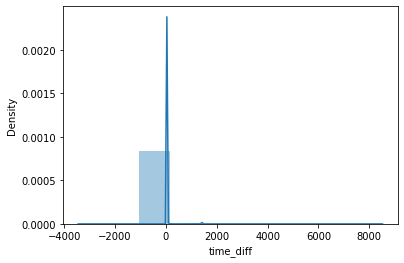

In [10]:
# distribution of the time_diff column
sns.distplot(jan2022['time_diff'], bins = 10)

In [11]:
jan2022['time_diff'].describe(percentiles=[0.02, 0.4, 0.95, 0.98, 0.99, 1])

count   2463931.00
mean         14.21
std          46.45
min       -3442.40
2%            1.80
40%           8.50
50%          10.20
95%          31.90
98%          42.20
99%          50.80
100%       8513.20
max        8513.20
Name: time_diff, dtype: float64

In [12]:
round(((jan2022['time_diff'] >= 1) & (jan2022['time_diff'] <= 50.80)).mean(),2)

0.98

#### The fraction of the records left after dropping the outliers is 0.98

In [13]:
jan2022 = jan2022[(jan2022['time_diff'] >= 1) & (jan2022['time_diff'] <= 50.80)]
jan2022.shape

(2409990, 20)

In [14]:
jan2022.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'time_diff'],
      dtype='object')

In [15]:
jan2022.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2409990 entries, 0 to 2463930
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee            floa

In [16]:
jan2022['PULocationID'] = jan2022['PULocationID'].astype(str)
jan2022['DOLocationID'] = jan2022['DOLocationID'].astype(str)

In [17]:
df = jan2022[['PULocationID', 'DOLocationID', 'trip_distance']]
df

,PULocationID,DOLocationID,trip_distance
0,142,236,3.80
1,236,42,2.10
2,166,166,0.97
3,114,68,1.09
4,68,163,4.30
...,...,...,...
2463926,90,170,1.32
2463927,107,75,4.19
2463928,113,246,2.10
2463929,148,164,2.92


In [18]:
train_dict = df.to_dict(orient='records')
train_dict

[{'PULocationID': '142', 'DOLocationID': '236', 'trip_distance': 3.8},
 {'PULocationID': '236', 'DOLocationID': '42', 'trip_distance': 2.1},
 {'PULocationID': '166', 'DOLocationID': '166', 'trip_distance': 0.97},
 {'PULocationID': '114', 'DOLocationID': '68', 'trip_distance': 1.09},
 {'PULocationID': '68', 'DOLocationID': '163', 'trip_distance': 4.3},
 {'PULocationID': '138', 'DOLocationID': '161', 'trip_distance': 10.3},
 {'PULocationID': '233', 'DOLocationID': '87', 'trip_distance': 5.07},
 {'PULocationID': '238', 'DOLocationID': '152', 'trip_distance': 2.02},
 {'PULocationID': '166', 'DOLocationID': '236', 'trip_distance': 2.71},
 {'PULocationID': '236', 'DOLocationID': '141', 'trip_distance': 0.78},
 {'PULocationID': '141', 'DOLocationID': '229', 'trip_distance': 1.91},
 {'PULocationID': '114', 'DOLocationID': '90', 'trip_distance': 0.82},
 {'PULocationID': '234', 'DOLocationID': '113', 'trip_distance': 0.73},
 {'PULocationID': '246', 'DOLocationID': '79', 'trip_distance': 2.16},
 

In [19]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)

In [20]:
X_train

<2409990x516 sparse matrix of type '<class 'numpy.float64'>'
	with 7229970 stored elements in Compressed Sparse Row format>

In [21]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=105',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',

In [22]:
len(dv.feature_names_)

516

In [23]:
target = jan2022['time_diff']
y_train = target.values

In [24]:
y_train

array([17.8,  8.4,  9. , ..., 11. , 12. , 27. ])

In [25]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [26]:
y_predict = lr.predict(X_train)

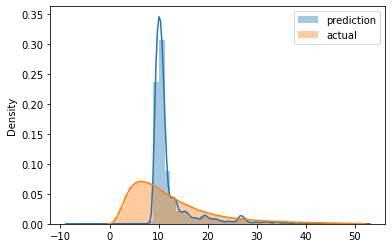

In [27]:
sns.distplot(y_predict, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [28]:
mean_squared_error(y_train, y_predict, squared=False)

6.707308957112428

In [29]:
y_train

array([17.8,  8.4,  9. , ..., 11. , 12. , 27. ])

##### validation

In [30]:
feb2022.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-02-01 00:06:58,2022-02-01 00:19:24,1.00,5.40,1.00,N,138,252,1,17.00,1.75,0.50,3.90,0.00,0.30,23.45,0.00,1.25
1,1,2022-02-01 00:38:22,2022-02-01 00:55:55,1.00,6.40,1.00,N,138,41,2,21.00,1.75,0.50,0.00,6.55,0.30,30.10,0.00,1.25
2,1,2022-02-01 00:03:20,2022-02-01 00:26:59,1.00,12.50,1.00,N,138,200,2,35.50,1.75,0.50,0.00,6.55,0.30,44.60,0.00,1.25
3,2,2022-02-01 00:08:00,2022-02-01 00:28:05,1.00,9.88,1.00,N,239,200,2,28.00,0.50,0.50,0.00,3.00,0.30,34.80,2.50,0.00
4,2,2022-02-01 00:06:48,2022-02-01 00:33:07,1.00,12.16,1.00,N,138,125,1,35.50,0.50,0.50,8.11,0.00,0.30,48.66,2.50,1.25


In [31]:
feb2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2979431 entries, 0 to 2979430
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [32]:
feb2022['time_diff'] = feb2022['tpep_dropoff_datetime'] - feb2022['tpep_pickup_datetime']
feb2022['time_diff'].head()

0   0 days 00:12:26
1   0 days 00:17:33
2   0 days 00:23:39
3   0 days 00:20:05
4   0 days 00:26:19
Name: time_diff, dtype: timedelta64[ns]

In [33]:
feb2022['time_diff'] = round(feb2022['time_diff'].dt.total_seconds() / 60, 1)
feb2022.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,time_diff
0,1,2022-02-01 00:06:58,2022-02-01 00:19:24,1.00,5.40,1.00,N,138,252,1,17.00,1.75,0.50,3.90,0.00,0.30,23.45,0.00,1.25,12.40
1,1,2022-02-01 00:38:22,2022-02-01 00:55:55,1.00,6.40,1.00,N,138,41,2,21.00,1.75,0.50,0.00,6.55,0.30,30.10,0.00,1.25,17.60
2,1,2022-02-01 00:03:20,2022-02-01 00:26:59,1.00,12.50,1.00,N,138,200,2,35.50,1.75,0.50,0.00,6.55,0.30,44.60,0.00,1.25,23.60
3,2,2022-02-01 00:08:00,2022-02-01 00:28:05,1.00,9.88,1.00,N,239,200,2,28.00,0.50,0.50,0.00,3.00,0.30,34.80,2.50,0.00,20.10
4,2,2022-02-01 00:06:48,2022-02-01 00:33:07,1.00,12.16,1.00,N,138,125,1,35.50,0.50,0.50,8.11,0.00,0.30,48.66,2.50,1.25,26.30


<Axes: xlabel='time_diff', ylabel='Density'>

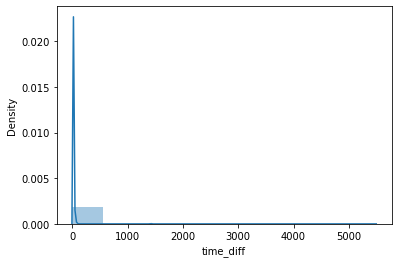

In [34]:
sns.distplot(feb2022['time_diff'], bins = 10)

In [35]:
feb2022['time_diff'].describe(percentiles=[.02, .9, .99])

count   2979431.00
mean         15.65
std          47.26
min          -1.00
2%            2.00
50%          11.20
90%          27.00
99%          59.50
max        5489.40
Name: time_diff, dtype: float64

In [36]:
feb2022 = feb2022[(feb2022['time_diff'] >= 2) & (feb2022['time_diff'] <= 60)]
feb2022

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,time_diff
0,1,2022-02-01 00:06:58,2022-02-01 00:19:24,1.00,5.40,1.00,N,138,252,1,17.00,1.75,0.50,3.90,0.00,0.30,23.45,0.00,1.25,12.40
1,1,2022-02-01 00:38:22,2022-02-01 00:55:55,1.00,6.40,1.00,N,138,41,2,21.00,1.75,0.50,0.00,6.55,0.30,30.10,0.00,1.25,17.60
2,1,2022-02-01 00:03:20,2022-02-01 00:26:59,1.00,12.50,1.00,N,138,200,2,35.50,1.75,0.50,0.00,6.55,0.30,44.60,0.00,1.25,23.60
3,2,2022-02-01 00:08:00,2022-02-01 00:28:05,1.00,9.88,1.00,N,239,200,2,28.00,0.50,0.50,0.00,3.00,0.30,34.80,2.50,0.00,20.10
4,2,2022-02-01 00:06:48,2022-02-01 00:33:07,1.00,12.16,1.00,N,138,125,1,35.50,0.50,0.50,8.11,0.00,0.30,48.66,2.50,1.25,26.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2979426,2,2022-02-28 23:50:00,2022-03-01 00:06:00,NaN,3.40,NaN,None,163,193,0,14.37,0.00,0.50,0.00,0.00,0.30,17.67,NaN,NaN,16.00
2979427,2,2022-02-28 23:06:57,2022-02-28 23:19:12,NaN,3.48,NaN,None,141,4,0,14.51,0.00,0.50,2.00,0.00,0.30,19.81,NaN,NaN,12.20
2979428,2,2022-02-28 23:48:13,2022-03-01 00:03:33,NaN,3.05,NaN,None,161,151,0,14.38,0.00,0.50,3.81,0.00,0.30,21.49,NaN,NaN,15.30
2979429,2,2022-02-28 23:56:41,2022-03-01 00:04:57,NaN,2.62,NaN,None,141,226,0,12.53,0.00,0.50,1.71,0.00,0.30,17.54,NaN,NaN,8.30
